<h2>Using Pandas and Networkx to Find the Influencers the #climatechange Twitter Dataset</h2>

<p>In this example, we explore measures of 'centrality' to identify the Twitter user who appear to have the most influence.</p>

<h2>Import Packages</h2>

In [29]:
import pandas as pd
import datetime
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os.path
from pprint import pprint

<h2>Read the #climatechange CSV Dataset</h2>

In [30]:
data_dir = '../data/twitter/'

In [31]:
tweet_df = pd.read_csv(os.path.join(data_dir, 'climatechange_tweets_all.csv'), \
                       parse_dates=['tweet_created_at', 'user_created_at'])

In [32]:
tweet_df.head()

,tweet_id,tweet_created_at,language,user_screen_name,user_created_at,user_id,followers_count,friends_count,time_zone,utc_offset,retweeted_status,retweet_id,retweet_user_screen_name,retweet_user_id,text
0,1068223635024941056,2018-11-29 19:22:15,en,JGuerreroN13,2017-06-07 20:21:48,872549171680694272,245,419,NaN,NaN,1,1068067040882233344,UNFCCC,17463923,RT @UNFCCC: Delegates from around the world ar...
1,1068223643765940226,2018-11-29 19:22:17,en,t_rustyboy1720,2017-09-23 03:53:34,911438362271031296,63,232,NaN,NaN,1,1068210734977490944,saskboy,6634632,RT @saskboy: I think we most often hear the wo...
2,1068223645330432001,2018-11-29 19:22:18,en,MissCJWright,2009-03-15 16:24:32,24544855,1383,4585,NaN,NaN,1,1068223231264505857,EcoSenseNow,1392956425,"RT @EcoSenseNow: It mat not be obvious, but Ei..."
3,1068223649222664194,2018-11-29 19:22:19,en,al_f,2009-07-17 00:05:50,57490401,333,377,NaN,NaN,1,1068181567510626310,ClimateComms,362642209,RT @ClimateComms: Most Americans now see #clim...
4,1068223660299677696,2018-11-29 19:22:21,en,Hawknana_,2013-12-21 03:16:04,2255917724,1751,3409,NaN,NaN,1,1068187254768590848,PortlandBEM,18030823,RT @PortlandBEM: Last week's federal climate c...


<h2>Extract Retweets</h2>

In [33]:
retweet_df = tweet_df[tweet_df.retweeted_status == 1]

In [34]:
retweet_df.head()

,tweet_id,tweet_created_at,language,user_screen_name,user_created_at,user_id,followers_count,friends_count,time_zone,utc_offset,retweeted_status,retweet_id,retweet_user_screen_name,retweet_user_id,text
0,1068223635024941056,2018-11-29 19:22:15,en,JGuerreroN13,2017-06-07 20:21:48,872549171680694272,245,419,NaN,NaN,1,1068067040882233344,UNFCCC,17463923,RT @UNFCCC: Delegates from around the world ar...
1,1068223643765940226,2018-11-29 19:22:17,en,t_rustyboy1720,2017-09-23 03:53:34,911438362271031296,63,232,NaN,NaN,1,1068210734977490944,saskboy,6634632,RT @saskboy: I think we most often hear the wo...
2,1068223645330432001,2018-11-29 19:22:18,en,MissCJWright,2009-03-15 16:24:32,24544855,1383,4585,NaN,NaN,1,1068223231264505857,EcoSenseNow,1392956425,"RT @EcoSenseNow: It mat not be obvious, but Ei..."
3,1068223649222664194,2018-11-29 19:22:19,en,al_f,2009-07-17 00:05:50,57490401,333,377,NaN,NaN,1,1068181567510626310,ClimateComms,362642209,RT @ClimateComms: Most Americans now see #clim...
4,1068223660299677696,2018-11-29 19:22:21,en,Hawknana_,2013-12-21 03:16:04,2255917724,1751,3409,NaN,NaN,1,1068187254768590848,PortlandBEM,18030823,RT @PortlandBEM: Last week's federal climate c...


<h2>Explore the Top Tweets and Retweeted Users</h2>

In [35]:
topretweets = retweet_df.groupby('retweet_id').size().sort_values(ascending=False).reset_index()
topretweeted = retweet_df.groupby('retweet_user_screen_name').size().sort_values(ascending=False).reset_index()

In [36]:
print(topretweets[:10])

            retweet_id     0
0  1066155330986541058  8923
1  1067149009867878400  3316
2  1065274149461987328  3108
3  1069278755041001472  2885
4  1069686443109466113  2509
5  1068113206525202433  2409
6  1069700156067594240  1956
7  1064191037571297280  1917
8  1068595221188042753  1892
9  1066352623358361600  1653


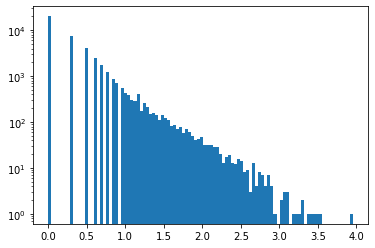

In [37]:
plt.hist(np.log10(topretweets[0]), bins=100);
plt.semilogy();

In [38]:
print(topretweeted[:10])

  retweet_user_screen_name      0
0              PaulEDawson  14947
1                   UNFCCC  14059
2              NancyPelosi   8923
3          jessphoenix2018   5870
4              MarkRuffalo   4074
5                SenMarkey   3278
6             Poseidon_NGO   3116
7            RealMAGASteve   2885
8            SenWhitehouse   2469
9               MikeHudema   2447


# Building a Retweet Graph

While we can get some useful statistics just from the retweet dataframe, it is useful to package some of that data into a network for further analyses.

We can create a weighted edge list linking twitter users in our retweet dataset, where a directed edge from a source user (retweeter) to a target user (retweeted) is included if source retweets target, with additional edge information in the form of a weight that indicates how many times source retweeted target in our dataset. This can be done very succinctly using the pandas groupby functionality, allowing us to group by (source, target) pairs.  The code cell below computes this edge list (in the form of a dataframe) and displays the head.

In [39]:
edge_df = retweet_df.groupby(['user_screen_name','retweet_user_screen_name']).size().reset_index()
edge_df.rename(columns={'user_screen_name': 'source', 'retweet_user_screen_name': 'target', 0: 'weight'}, inplace=True)
edge_df.head()

,source,target,weight
0,000120o,DiEM_25,1
1,000120o,EricPiolle,1
2,000120o,GenerationsBXL,1
3,00023E,dailystarnews,1
4,000Netty00,CClimateAction,1


From this edge list, we can construct a directed graph (object of type nx.DiGraph) with the included edge weights, using the networkx function <code>nx.from_pandas_edgelist</code>.  We want to create a directed graph because these retweet edges have a meaningful directionality (from retweeter to retweeted).  We can also print out some basic statistics about the graph, such as the number of nodes and edges.

In [40]:
G = nx.from_pandas_edgelist(edge_df, create_using=nx.DiGraph, edge_attr=True)
print(G.number_of_nodes())
print(G.number_of_edges())

170995
264644


It is often of interest as to whether a network forms one complete, connected component, or whether it is broken up into multiple disjoint components.  For a directed network such as the one we have constructed here, there are two different types of connnectivity to consider: weak connectivity and strong connectivity.  The weakly connected components of a directed graph are comprised of those nodes that can be reached from one another by traversing edges independent of the directionality of those edges (i.e., as if we converted the directed network to an undirected one).  The strongly connected components are comprised of those nodes that can only be reached from one another by following the directed edges of the graph, which is a much stronger constraint on connectivity.  We can evaluate and print the number of both weakly and strongly connected components in our graph, using predefined functions in nx.

In [41]:
print(nx.number_weakly_connected_components(G))
print(nx.number_strongly_connected_components(G))

5059
168769


We can also compute the sizes (number of nodes) for each weakly connected component, and print the largest sizes.  We see that approximately 92% of the nodes in the network are part of the largest component, and that the remainder are much smaller in size.

In [42]:
weak_sizes = sorted([len(c) for c in nx.weakly_connected_components(G)], reverse=True)
print(weak_sizes[:10])

[157841, 48, 37, 28, 26, 25, 25, 21, 20, 20]


## Network Degrees

The degree of a node in a graph represents how many other nodes it is connected to.  For a directed graph, there are two degrees, the in-degree and out-degree, depending on whether an edge is incoming or outgoing from a node.  Twitter users with large in-degree are those who are retweeted a lot, and thus are perhaps serving as important influencers within the social network.  Because our graph has weighted edges, we can compute either simply the in-degree (number of incoming edges) or the weighted in-degree (sum of all weights on incoming edges), the latter of which would indicate the total number of retweets from that user.

In [43]:
in_degrees = G.in_degree()
in_degrees_sorted = sorted(in_degrees, key=lambda kv:kv[1], reverse=True)
in_degrees_sorted[:10]

[('UNFCCC', 9165),
 ('NancyPelosi', 8880),
 ('PaulEDawson', 5876),
 ('jessphoenix2018', 5312),
 ('MarkRuffalo', 3678),
 ('SenMarkey', 3100),
 ('RealMAGASteve', 2848),
 ('ed_hawkins', 2396),
 ('TravelWithXtina', 2175),
 ('SenWhitehouse', 2132)]

#### Exercise: Extend the code above to compute weighted in degrees

In [ ]:
# YOUR CODE HERE

Solution here...

In [44]:
weighted_in_degrees = G.in_degree(weight='weight')
weighted_in_degrees_sorted = sorted(weighted_in_degrees, key=lambda kv:kv[1], reverse=True)
weighted_in_degrees_sorted[:10]

[('PaulEDawson', 14947),
 ('UNFCCC', 14059),
 ('NancyPelosi', 8923),
 ('jessphoenix2018', 5870),
 ('MarkRuffalo', 4074),
 ('SenMarkey', 3278),
 ('Poseidon_NGO', 3116),
 ('RealMAGASteve', 2885),
 ('SenWhitehouse', 2469),
 ('MikeHudema', 2447)]

<h2>Closeness Centrality</h2>
<p>Closeness centrality is a measure of the extent to which a particular node is close to other nodes. The node which requires the fewest overall 'hops' for other users to reach it has the highest 'closeness'. In order to perform a global closeness centrality calculation on an entire graph, the graph must be fully connected. This means that every node has a path to every other node. Our dataset is not a connected graph, but we can still perform calculations on individual nodes. For this example, we will calculate closeness centrality for the top 100 retweeted users in our dataset. </p>

In [47]:
for i in range(10):
    topretweeted_screen_name = topretweeted['retweet_user_screen_name'][i]
    nx_cc = nx.closeness_centrality(G, u=topretweeted_screen_name)
    print(str(i) + " " + topretweeted_screen_name + " " + str(nx_cc))

0 PaulEDawson 0.06906497612855028
1 UNFCCC 0.11144289912839853
2 NancyPelosi 0.06334007674767712
3 jessphoenix2018 0.06303324047572335
4 MarkRuffalo 0.053675460141634726
5 SenMarkey 0.06499481526229721
6 Poseidon_NGO 0.037780729827207135
7 RealMAGASteve 0.02952882731050731
8 SenWhitehouse 0.04979530328053893
9 MikeHudema 0.06537302087006597
